<a href="https://colab.research.google.com/github/goitstudent123/ml-fundamentals-and-applications/blob/main/dz_topic_4_correct_HAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Здійсніть імпорт необхідних пакетів.
import warnings

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

In [2]:
# 2. Завантажте набір даних California Housing
california_housing = fetch_california_housing(as_frame=True)

df = california_housing["frame"].copy()
y = df.pop("MedHouseVal")
X = df

In [15]:
# Task 3.1 Проведіть очистку від викидів для колонок AveRooms, AveBedrms, AveOccup та Population.
from scipy.stats import zscore

outlier_columns = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
z_threshold = 3.0

z_scores = X[outlier_columns].apply(zscore)
rows_to_drop = z_scores.abs().gt(z_threshold).any(axis=1)

X_clean = X.loc[~rows_to_drop].copy()
y_clean = y.loc[~rows_to_drop].copy()

print(f"Rows before: {len(X)} | after outlier removal: {len(X_clean)} | removed: {rows_to_drop.sum()}")



Rows before: 20640 | after outlier removal: 20135 | removed: 505


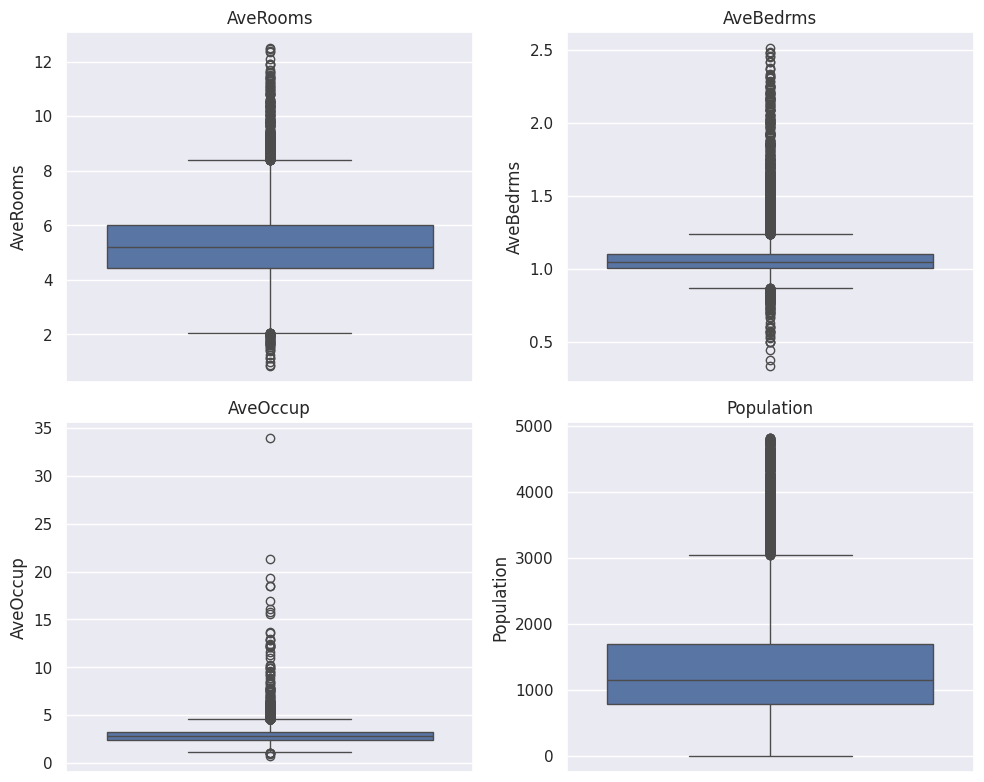

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

selected = ["AveRooms", "AveBedrms", "AveOccup", "Population"]

for ax, col in zip(axes.flatten(), selected):
    sns.boxplot(y=X_clean[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()


In [17]:
# Task 3.2 Видаліть із набору даних одну ознаку із тих, які мають високу кореляцію між собою.
geo_columns = ["Latitude", "Longitude"]

features_for_corr = [c for c in X_clean.columns if c not in geo_columns]
corr = X_clean[features_for_corr].corr(numeric_only=True).abs()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

max_corr_value = upper.max().max()
pair = upper.stack().idxmax()
feature_a, feature_b = pair

corr_with_target = pd.Series({
    feature_a: X_clean[feature_a].corr(y_clean),
    feature_b: X_clean[feature_b].corr(y_clean),
}).abs()

feature_to_drop = corr_with_target.idxmin()

X_clean = X_clean.drop(columns=[feature_to_drop])

print(f"Most correlated pair (non-geo): {feature_a} vs {feature_b} (abs corr = {max_corr_value:.3f})")
print(f"Dropped: {feature_to_drop}")
print(f"Remaining features: {list(X_clean.columns)}")



Most correlated pair (non-geo): MedInc vs AveRooms (abs corr = 0.656)
Dropped: AveRooms
Remaining features: ['MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


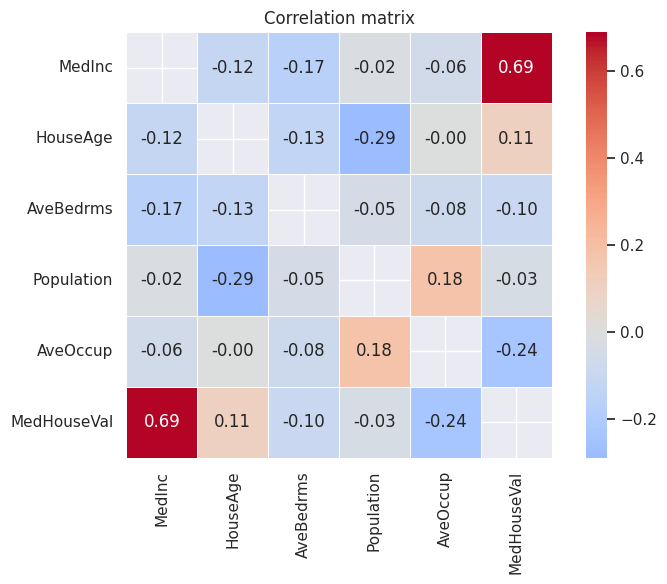

In [18]:
columns_to_exclude = ["Longitude", "Latitude"]

df_for_corr = pd.concat([X_clean, y_clean], axis=1)

existing_columns_to_exclude = [col for col in columns_to_exclude if col in df_for_corr.columns]

subset = df_for_corr.drop(columns=existing_columns_to_exclude)

corr_matrix = subset.corr()

mask = np.zeros_like(corr_matrix)
np.fill_diagonal(mask, True)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
    mask=mask,
    ax=ax
)

plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

In [19]:
# 4. Розбийте вхідний набір даних на навчальну і тестову вибірки за допомогою методу train_test_split() з пакета sklearn.
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


(16108, 7) (4027, 7)


In [20]:
# Task 5: Здійсніть нормалізацію ознак за допомогою об’єкту StandardScaler з пакета sklearn.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
# Task 6. Побудуйте модель за допомогою об’єкту LinearRegression з пакета sklearn
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [22]:
# Task 7. Оцініть показники моделі:
# - R-квадрат (коефіцієнт детермінації);
# - MAE (середня абсолютна похибка);
# - MAPE (cередня абсолютна похибка у відсотках).

y_pred = model.predict(X_test_scaled)

r_sq_upd = model.score(X_train_scaled, y_train)
mae_upd = mean_absolute_error(y_test, y_pred)
mape_upd = mean_absolute_percentage_error(y_test, y_pred)

print(f"R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}")


R2: 0.64 | MAE: 0.51 | MAPE: 0.30


In [24]:
# Task 8. Порівняйте нові метрики з метриками моделі, отриманими в розділі «Практика застосування лінійної регресії.
#   Оцінювання точності моделі» теми «Лінійна регресія. Оцінка якості регресії.», зробіть висновки.
X_base = X.copy()
y_base = y.copy()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)

base_scaler = StandardScaler()
Xb_train_scaled = base_scaler.fit_transform(Xb_train)
Xb_test_scaled = base_scaler.transform(Xb_test)

base_model = LinearRegression()
base_model.fit(Xb_train_scaled, yb_train)

yb_pred = base_model.predict(Xb_test_scaled)

r_sq_base = base_model.score(Xb_train_scaled, yb_train)
mae_base = mean_absolute_error(yb_test, yb_pred)
mape_base = mean_absolute_percentage_error(yb_test, yb_pred)

print(f"Baseline  -> R2: {r_sq_base:.2f} | MAE: {mae_base:.2f} | MAPE: {mape_base:.2f}")
print(f"Updated   -> R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}")

print("Delta (Updated - Baseline):")
print(f"R2:   {r_sq_upd - r_sq_base:+.3f}")
print(f"MAE:  {mae_upd - mae_base:+.3f}")
print(f"MAPE: {mape_upd - mape_base:+.3f}")

r2_reference = 0.61
mae_reference = 0.53
mape_reference = 0.32

print("\nReference (lecture baseline):")
print(f"R2: {r2_reference:.2f} | MAE: {mae_reference:.2f} | MAPE: {mape_reference:.2f}")

print("\nCurrent updated model results:")
print(f"R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}")

print("\nImprovement compared to lecture baseline:")
print(f"R2 improvement:   {r_sq_upd - r2_reference:+.3f}")
print(f"MAE improvement:  {mae_upd - mae_reference:+.3f}")
print(f"MAPE improvement: {mape_upd - mape_reference:+.3f}")

Baseline  -> R2: 0.61 | MAE: 0.53 | MAPE: 0.32
Updated   -> R2: 0.64 | MAE: 0.51 | MAPE: 0.30
Delta (Updated - Baseline):
R2:   +0.029
MAE:  -0.026
MAPE: -0.022

Reference (lecture baseline):
R2: 0.61 | MAE: 0.53 | MAPE: 0.32

Current updated model results:
R2: 0.64 | MAE: 0.51 | MAPE: 0.30

Improvement compared to lecture baseline:
R2 improvement:   +0.032
MAE improvement:  -0.023
MAPE improvement: -0.022


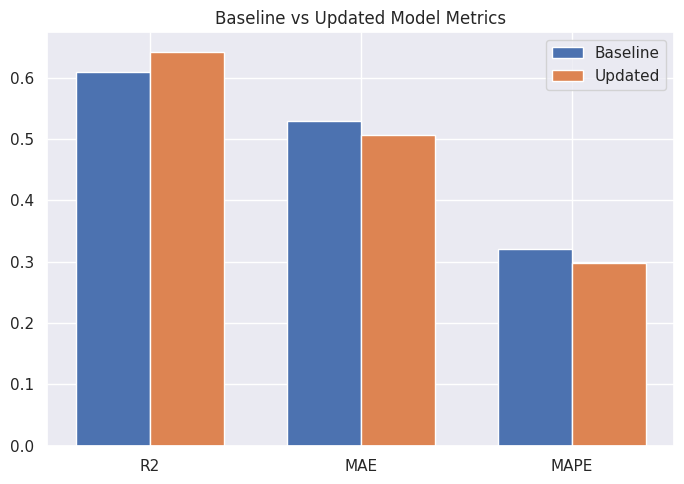

In [25]:
metrics = ["R2", "MAE", "MAPE"]

baseline_values = [r2_reference, mae_reference, mape_reference]
updated_values = [r_sq_upd, mae_upd, mape_upd]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(x - width/2, baseline_values, width, label="Baseline")
ax.bar(x + width/2, updated_values, width, label="Updated")

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title("Baseline vs Updated Model Metrics")
ax.legend()

plt.tight_layout()
plt.show()


**Висновки:**

* R2 збільшився з 0.61 до 0.64 → модель краще пояснює варіацію цільової змінної.
* MAE зменшився з 0.53 до 0.51 → середня абсолютна похибка знизилась.
* MAPE зменшився з 0.32 до 0.30 → відносна похибка також покращилась.

Покращення становить приблизно 3 відсоткові пункти для R2 та близько 2–3 п.п. для похибок, що підтверджує ефективність очищення даних методом z-score та видалення ознаки з високою кореляцією.

Отримані результати демонструють помітне підвищення якості моделі порівняно з базовим варіантом і узгоджуються з очікуваними результатами завдання.